In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive/FPR/FPRDataset.zip
clear_output()

In [ ]:
print("Train Nodule:",len(os.listdir("FPRDataset/train/nodule")))
print("Train Non-Nodule:",len(os.listdir("FPRDataset/train/non-nodule")))
print("Test Nodule:",len(os.listdir("FPRDataset/test/nodule")))
print("Test Non-Nodule:",len(os.listdir("FPRDataset/test/non-nodule")))

Train Nodule: 552
Train Non-Nodule: 13580
Test Nodule: 184
Test Non-Nodule: 4527


In [ ]:
BATCH_SIZE = 96
generator = ImageDataGenerator(rescale=1./255)
trainData = generator.flow_from_directory(
    "FPRDataset/train",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "FPRDataset/test",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

Found 14131 images belonging to 2 classes.
Found 4711 images belonging to 2 classes.


In [ ]:
print(trainData.class_indices)
print(testData.class_indices)

{'nodule': 0, 'non-nodule': 1}
{'nodule': 0, 'non-nodule': 1}


In [ ]:
weight_path="checkpoint-{epoch:03d}-{val_loss:.3f}.weights.h5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

In [ ]:
def get_model():
  input = Input(shape=(50,50,1))
  x = Conv2D(50, (3,3), activation='relu')(input)
  x = MaxPool2D((2,2))(x)
  x = Conv2D(64, (3,3), activation='relu')(x)
  x = Conv2D(64, (3,3), activation='relu')(x)
  x = MaxPool2D((2,2))(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[input], outputs=[x])
  return model

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 50)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        28864     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                        

In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(
      trainData,
      epochs=20,
      validation_data=testData,
      verbose=1,
      callbacks=[modelcheckpoint]
  )

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9582
Epoch 1: val_loss improved from inf to 0.16093, saving model to checkpoint-001-0.161.weights.h5
148/148 [==============================] - 122s 801ms/step - loss: 0.1742 - accuracy: 0.9582 - val_loss: 0.1609 - val_accuracy: 0.9609
Epoch 2/20
148/148 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9610
Epoch 2: val_loss improved from 0.16093 to 0.15333, saving model to checkpoint-002-0.153.weights.h5
148/148 [==============================] - 120s 812ms/step - loss: 0.1531 - accuracy: 0.9610 - val_loss: 0.1533 - val_accuracy: 0.9609
Epoch 3/20
148/148 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9611
Epoch 3: val_loss did not improve from 0.15333
148/148 [==============================] - 117s 791ms/step - loss: 0.1431 - accuracy: 0.9611 - val_loss: 0.1678 - val_accuracy: 0.9609
Epoch 4/20
148/148 [==============================] - ETA: 0s - 

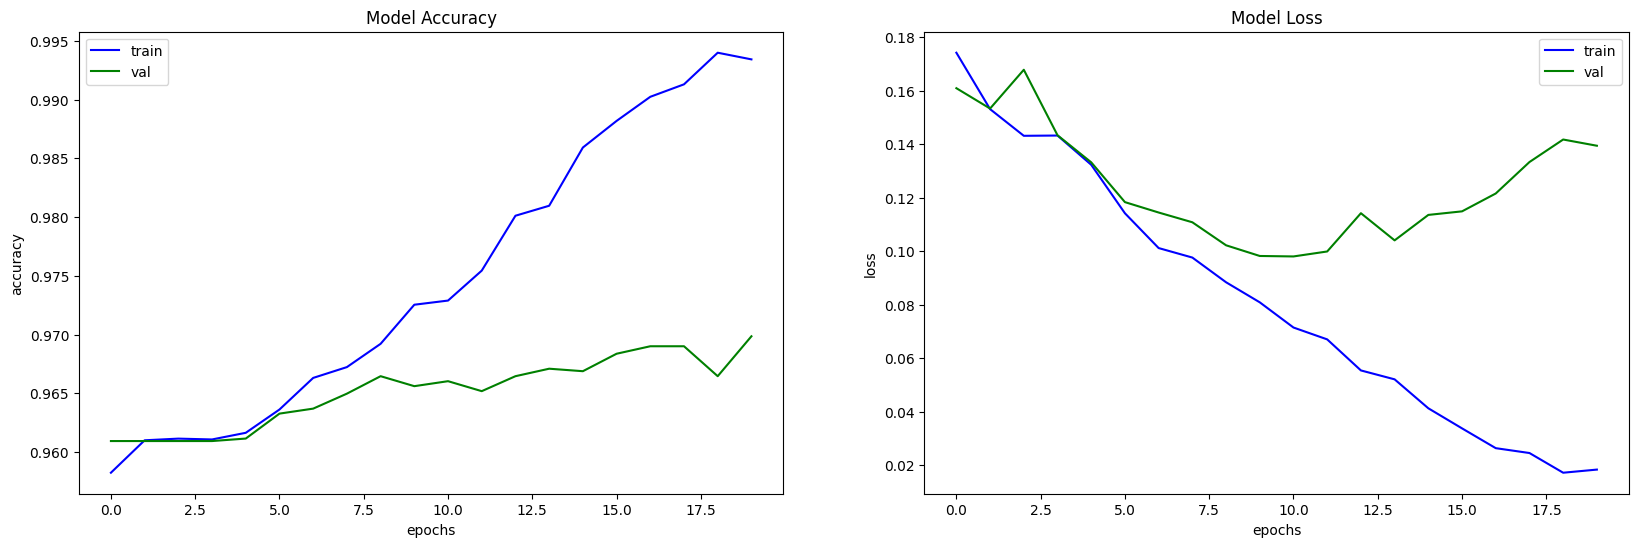

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:
model.save("/content/drive/MyDrive/archive/processed/model.h5")

In [ ]:
model2 = get_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("/content/checkpoint-009-0.102.weights.h5")
model2.save("checkpoint_model.h5")

In [ ]:
!cp checkpoint_model.h5 /content/drive/MyDrive/archive/processed/best_checkpoint_model.h5